In [1]:
%%javascript

window.load_remote_theme = false
var theme_url = "https://drostehk.github.io/ipynb-theme/";
var asset_url = 'https://raw.githubusercontent.com/tijptjik/DS_assets/master/';

window.load_local_theme = function(){
    var hostname = document.location.hostname
    return ((hostname == "localhost" || hostname == '127.0.0.1') && !load_remote_theme)
}

var url = load_local_theme() ? document.location.origin + "/files/theme/custom.js" : theme_url + 'custom.js'

$.getScript(url)

<IPython.core.display.Javascript object>

## Feature Engineering II

> Wit. 

<footer>~ PCA ( quote )</footer>

![break](assets/agenda.png)

1. Feature Construction
1. Dimensionality Reduction
1. Principal Components Analysis (PCA)
1. Singular Value Decomposition
1. Kernel Methods In PCA

**Labs**
1. Dimensionality Reduction In Scikit-learn

## Feature Construction

Feature importance and selection can inform you about the objective utility of features, but those features have to come from somewhere. You need to manually create them. This requires spending a lot of time with actual sample data (not aggregates) and thinking about the underlying form of the problem, structures in the data and how best to expose them to predictive modeling algorithms. With tabular data, it often means a mixture of aggregating or combining features to create new features, and decomposing or splitting features to create new features.

### Decompose Categorical Attributes

Imagine you have a categorical attribute, like “Item_Color” that can be `Red`, `Blue` or `Unknown`.

`Unknown` may be special, but to a model, it looks like just another colour choice. It might be beneficial to better expose this information. You could create a new binary feature called “Has_Color” and assign it a value of “1” when an item has a color and “0” when the color is unknown. Going a step further, you could create a binary feature for each value that `Item_Color` has. This would be three binary attributes: `Is_Red`, `Is_Blue` and `Is_Unknown`.

These additional features could be used instead of the `Item_Color` feature (if you wanted to try a simpler linear model) or in addition to it (if you wanted to get more out of something like a decision tree).

#### Weighted Random Sample

In [8]:
import random

random.sample([1,2,3,4], 2)

[1, 3]

In [10]:
%matplotlib inline

import numpy as np
import pandas as pd

colour_set = ['Red', 'Green', 'Blue', 'Unknown']
weights = [0.45,0.25,0.20,0.1]

def wr_index(weights,k=5):
    return np.array(weights).cumsum() \
        .searchsorted(np.random.sample(k))

def sample_wr(samples, n, weights):
    assert len(samples) == len(weights)
    return map(lambda x : samples[x], wr_index(weights, n))

In [11]:
# Let's break it down
np.array(weights).cumsum()

array([ 0.45,  0.7 ,  0.9 ,  1.  ])

In [18]:
np.random.sample(5)

array([ 0.20895421,  0.50482103,  0.48972528,  0.80153428,  0.59215504])

In [15]:
np.array(weights).cumsum().searchsorted(np.random.sample(5))

array([0, 2, 1, 0, 0])

In [326]:
sample_wr(colour_set, 10, weights)

['Red',
 'Green',
 'Blue',
 'Unknown',
 'Green',
 'Blue',
 'Red',
 'Red',
 'Red',
 'Green']

In [16]:
colours = sample_wr(colour_set, 1000, weights)
df = pd.DataFrame(colours, columns=['colour'])
df.head()

,colour
0,Green
1,Blue
2,Green
3,Green
4,Red


### Challenge : Decompose Categorical Attributes

1. Based on the above `df`, create a binary feature 'has_colour' which indicates whether a row has a valid colour value or not.
1. Based on the above `df`, create dummy variables based on the `colours` column.

#### Solution

In [ ]:
import base64
answer = 'CiMgIGNyZWF0ZSBhIGJpbmFyeSBmZWF0dXJlICdoYXNfY29sb3VyJwpkZlsnaGFzX2NvbG91ciddID0gZGYuY29sb3VyICE9ICdVbmtub3duJwpkZi5oYXNfY29sb3VyID0gZGYuaGFzX2NvbG91ci5hc3R5cGUoJ2ludCcpCgojIGNyZWF0ZSBkdW1teSB2YXJpYWJsZXMKcGQuZ2V0X2R1bW1pZXMoZGYuY29sb3VyKQ=='
base64.b64decode(answer)

### Decompose a Date-Time

A date-time contains a lot of information that can be difficult for a model to take advantage of in it’s native form, such as ISO 8601 (i.e. 2014-09-20T20:45:40Z). If you suspect there are relationships between times and other attributes, you can decompose a date-time into constituent parts that may allow models to discover and exploit these relationships.

For example, you may suspect that there is a relationship between the time of day and other attributes. You could create a new numerical feature called `Hour_of_Day` for the hour that might help a regression model. You could create a new ordinal feature called `Part_Of_Day` with 4 values `Morning`, `Midday`, `Afternoon`, `Night` with whatever hour boundaries you think are relevant. This might be useful for a decision tree.

You can use similar approaches to pick out time of week relationships, time of month relationships and various structures of seasonality across a year. Date-times are rich in structure and if you suspect there is time dependence in your data, take your time and tease them out.

In [29]:
def random_date(start, end, position=None):
    start, end = pd.Timestamp(start), pd.Timestamp(end)
    delta = (end - start).total_seconds()
    if position is None:
        offset = np.random.uniform(0., delta)
    else:
        offset = position * delta
    offset = pd.offsets.Second(offset)
    t = start + offset
    return t

#### With specified timestamps

In [30]:
[random_date(start="1/1/2008 1:30 PM", end="1/1/2009 4:50 AM") for _ in range(10)]

[Timestamp('2008-01-31 19:52:41'),
 Timestamp('2008-04-16 05:32:50'),
 Timestamp('2008-06-20 10:39:01'),
 Timestamp('2008-09-20 06:37:03'),
 Timestamp('2008-02-29 16:26:53'),
 Timestamp('2008-05-30 22:09:26'),
 Timestamp('2008-01-04 04:50:01'),
 Timestamp('2008-03-11 06:12:15'),
 Timestamp('2008-10-09 20:42:30'),
 Timestamp('2008-03-12 11:06:49')]

#### Based on pandas datetime objects

In [38]:
pd.datetime.now()

datetime.datetime(2015, 5, 9, 11, 3, 24, 143567)

In [331]:
# Past 10 days
[random_date(pd.datetime.now() - pd.offsets.Day(10), pd.datetime.now()) for _ in range(10)]

[Timestamp('2015-05-07 00:04:01.823746'),
 Timestamp('2015-05-08 10:57:47.824239'),
 Timestamp('2015-05-06 22:44:54.824561'),
 Timestamp('2015-05-07 06:28:09.824971'),
 Timestamp('2015-05-07 13:31:28.825279'),
 Timestamp('2015-05-07 20:28:30.825559'),
 Timestamp('2015-05-09 02:47:11.825853'),
 Timestamp('2015-05-06 19:47:10.826139'),
 Timestamp('2015-05-07 04:30:49.826414'),
 Timestamp('2015-05-06 21:59:43.826693')]

In [40]:
sudo pip install -U pandas

'0.16.0'

In [39]:
dates = [random_date("1/1/2010", pd.datetime.now()) for _ in range(1000)]
df_date = pd.DataFrame(dates, columns=['date'])
df_date.head()

,date
0,2011-07-02 16:14:15
1,2014-02-22 21:49:06
2,2010-02-19 06:19:41
3,2010-06-07 05:58:38
4,2013-11-30 02:48:46


### Challenge : Decompose Datetime

1. Using `df_date`, parse the date out into `year`, `month` and `day` features
1. Using `df_date`, create dummy variables for days of the week.
1. Using `df_date`, create a new variables which indicates whether the instance is a weekday or not.
1. Using `df_date`, sort all the instances by date, and create a new variable which indicates how much time (in seconds) has elapsed since the last instance.

A deeper look at [drawing features from time series patterns](http://datascience.stackexchange.com/questions/2368/machine-learning-features-engineering-from-date-time-data)

#### Solution

In [ ]:
answer = 'CiMgIHBhcnNlIHRoZSBkYXRlIG91dCBpbnRvIHllYXIsIG1vbnRoIGFuZCBkYXkgZmVhdHVyZXMKZHRzID0gbGlzdChkZl9kYXRlLmRhdGUuYXBwbHkobGFtYmRhIHg6IFt4LnllYXIsIHgubW9udGgsIHguZGF5XSkudmFsdWVzKQpkZl9kYXRlX2NvbXAgPSBwZC5EYXRhRnJhbWUoZHRzLCBjb2x1bW5zPVsneWVhcicsICdtb250aCcsJ2RheSddKQpkZl9kYXRlX2NvbXAuaGVhZCgpCnBkLmNvbmNhdChbZGZfZGF0ZSwgZGZfZGF0ZV9jb21wXSwgYXhpcz0xKS5oZWFkKCk='
base64.b64decode(answer)

In [70]:
#  parse the date out into year, month and day features
dts = list(df_date.date.apply(lambda x: [x.year, x.month, x.day]).values)
df_date_comp = pd.DataFrame(dts, columns=['year', 'month','day'])
# df_date_comp.head()
pd.concat([df_date, df_date_comp], axis=1).head()

,date,year,month,day
0,2011-07-02 16:14:15,2011,7,2
1,2014-02-22 21:49:06,2014,2,22
2,2010-02-19 06:19:41,2010,2,19
3,2010-06-07 05:58:38,2010,6,7
4,2013-11-30 02:48:46,2013,11,30


In [57]:
answer = 'IyBPUgoKZCA9IGRmX2RhdGUuZGF0ZS5kdApjb2xzID0gWyd5ZWFyJywgJ21vbnRoJywnZGF5J10KCmRmX2RhdGVfY29tcCA9IHBkLmNvbmNhdChbZC5fX2dldGF0dHJpYnV0ZV9fKGMpIGZvciBjIGluIGNvbHNdLCBheGlzPTEpCmRmX2RhdGVfY29tcC5jb2x1bW5zID0gY29scwpwZC5jb25jYXQoW2RmX2RhdGUsIGRmX2RhdGVfY29tcF0sIGF4aXM9MSkuaGVhZCgp'
# for line in base64.b64decode(answer).split('\n'):
#     print line

# OR

d = df_date.date.dt
cols = ['year', 'month','day']

df_date_comp = pd.concat([d.__getattribute__(c) for c in cols], axis=1)
df_date_comp.columns = cols
pd.concat([df_date, df_date_comp], axis=1).head()


In [54]:
# pd.DataFrame.__getitem__??

In [89]:
# OR

d = df_date.date.dt
cols = ['year', 'month','day']

df_date_comp = pd.concat([d.__getattribute__(c) for c in cols], axis=1)
df_date_comp.columns = cols
pd.concat([df_date, df_date_comp], axis=1).head()

,date,year,month,day
0,2011-07-02 16:14:15,2011,2011,2011
1,2014-02-22 21:49:06,2014,2014,2014
2,2010-02-19 06:19:41,2010,2010,2010
3,2010-06-07 05:58:38,2010,2010,2010
4,2013-11-30 02:48:46,2013,2013,2013


In [43]:
answer = 'CndlZWtkYXlzID0gWydNb24nLCdUdWUnLCdXZWQnLCdUaHUnLCdGcmknLCdTYXQnLCdTdW4nXQpkZl93ZWVrZGF5cyA9IHBkLmdldF9kdW1taWVzKGRmX2RhdGUuZGF0ZS5kdC5kYXlvZndlZWspCmRmX3dlZWtkYXlzLmNvbHVtbnMgPSB3ZWVrZGF5cwpwZC5jb25jYXQoW2RmX2RhdGUsIGRmX2RhdGVfY29tcCwgZGZfd2Vla2RheXNdLCBheGlzPTEpLmhlYWQoKQo='
base64.b64decode(answer)

"\nweekdays = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']\ndf_weekdays = pd.get_dummies(df_date.date.dt.dayofweek)\ndf_weekdays.columns = weekdays\npd.concat([df_date, df_date_comp, df_weekdays], axis=1).head()\n"

In [67]:
weekdays = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
df_weekdays = pd.get_dummies(df_date.date.dt.dayofweek)
df_weekdays.columns = weekdays
pd.concat([df_date, df_date_comp, df_weekdays], axis=1).head()

,date,year,month,day,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,2011-07-02 16:14:15,2011,7,2,0,0,0,0,0,1,0
1,2014-02-22 21:49:06,2014,2,22,0,0,0,0,0,1,0
2,2010-02-19 06:19:41,2010,2,19,0,0,0,0,1,0,0
3,2010-06-07 05:58:38,2010,6,7,1,0,0,0,0,0,0
4,2013-11-30 02:48:46,2013,11,30,0,0,0,0,0,1,0


In [44]:
answer = 'Cmlzd2Vla2VuZCA9IGRmX2RhdGUuZGF0ZS5kdC5kYXlvZndlZWsgPiA0CmRmX2lzd2Vla2VuZCA9IHBkLkRhdGFGcmFtZShpc3dlZWtlbmQsIGNvbHVtbnM9Wydpc193ZWVrZW5kJ10sIGR0eXBlPW5wLmludCkKcGQuY29uY2F0KFtkZl9kYXRlLCBkZl9kYXRlX2NvbXAsIGRmX3dlZWtkYXlzLCBkZl9pc3dlZWtlbmRdLCBheGlzPTEpLmhlYWQoKQo='
base64.b64decode(answer)

"\nisweekend = df_date.date.dt.dayofweek > 4\ndf_isweekend = pd.DataFrame(isweekend, columns=['is_weekend'], dtype=np.int)\npd.concat([df_date, df_date_comp, df_weekdays, df_isweekend], axis=1).head()\n"

In [79]:
isweekend = df_date.date.dt.dayofweek > 4
df_isweekend = pd.DataFrame(isweekend, columns=['is_weekend'], dtype=np.int)
pd.concat([df_date, df_date_comp, df_weekdays, df_isweekend], axis=1).head()

,date,year,month,day,Mon,Tue,Wed,Thu,Fri,Sat,Sun,is_weekend
0,2011-07-02 16:14:15,2011,7,2,0,0,0,0,0,1,0,1
1,2014-02-22 21:49:06,2014,2,22,0,0,0,0,0,1,0,1
2,2010-02-19 06:19:41,2010,2,19,0,0,0,0,1,0,0,0
3,2010-06-07 05:58:38,2010,6,7,1,0,0,0,0,0,0,0
4,2013-11-30 02:48:46,2013,11,30,0,0,0,0,0,1,0,1


In [45]:
answer = 'CmRmX2RhdGVfc29ydGVkID0gZGZfZGF0ZS5zb3J0KFsnZGF0ZSddKQp0aW1lX2RpZmZlcmVuY2UgPSBkZl9kYXRlX3NvcnRlZCAtIGRmX2RhdGVfc29ydGVkLnNoaWZ0KCkKdGltZV9kaWZmZXJlbmNlID0gcGQuRGF0YUZyYW1lKHRpbWVfZGlmZmVyZW5jZS5maWxsbmEoMCkuZGF0ZS5kdC5zZWNvbmRzKQp0aW1lX2RpZmZlcmVuY2UuY29sdW1ucyA9IFsndGltZWRlbHRhJ10KcGQuY29uY2F0KFtkZl9kYXRlLCBkZl9kYXRlX2NvbXAsIGRmX3dlZWtkYXlzLCBkZl9pc3dlZWtlbmQsIHRpbWVfZGlmZmVyZW5jZV0sIGF4aXM9MSkuaGVhZCgpCg=='
base64.b64decode(answer)

"\ndf_date_sorted = df_date.sort(['date'])\ntime_difference = df_date_sorted - df_date_sorted.shift()\ntime_difference = pd.DataFrame(time_difference.fillna(0).date.dt.seconds)\ntime_difference.columns = ['timedelta']\npd.concat([df_date, df_date_comp, df_weekdays, df_isweekend, time_difference], axis=1).head()\n"

In [82]:
df_date_sorted = df_date.sort(['date'])
time_difference = df_date_sorted - df_date_sorted.shift()
time_difference = pd.DataFrame(time_difference.fillna(0).date.dt.seconds)
time_difference.columns = ['timedelta']
pd.concat([df_date, df_date_comp, df_weekdays, df_isweekend, time_difference], axis=1).head()

,date,year,month,day,Mon,Tue,Wed,Thu,Fri,Sat,Sun,is_weekend,timedelta
0,2011-07-02 16:14:15,2011,7,2,0,0,0,0,0,1,0,1,70571
1,2014-02-22 21:49:06,2014,2,22,0,0,0,0,0,1,0,1,5151
2,2010-02-19 06:19:41,2010,2,19,0,0,0,0,1,0,0,0,7321
3,2010-06-07 05:58:38,2010,6,7,1,0,0,0,0,0,0,0,38933
4,2013-11-30 02:48:46,2013,11,30,0,0,0,0,0,1,0,1,51671


### Reframe Numerical Quantities

Your data is very likely to contain quantities, which can be reframed to better expose relevant structures. This may be a transform into a new unit or the decomposition of a rate into time and amount components. You may have a quantity like a weight, distance or timing. A linear transform may be useful to regression and other scale dependent methods.

For example, you may have `Item_Weight` in grams, with a value like `6289`. You could create a new feature with this quantity in `kilograms` as `6.289` or rounded kilograms like 6. If the domain is shipping data, perhaps kilograms is sufficient or more useful (less noisy) a precision for `Item_Weight`. The `Item_Weight` could be split into two features: `Item_Weight_Kilograms` and `Item_Weight_Remainder_Grams`, with example values of `6` and `289` respectively.

There may be domain knowledge that items with a weight above `4` incur a higher taxation rate. That magic domain number could be used to create a new binary feature `Item_Above_4kg` with a value of “1” for our example of 6289 grams.

You may also have a quantity stored as a rate or an aggregate quantity for an interval. For example, `Num_Customer_Purchases` aggregated over a year. In this case you may want to go back to the data collection step and create new features in addition to this aggregate and try to expose more temporal structure in the purchases, like perhaps seasonality. For example, the following new binary features could be created: `Purchases_Summer`, `Purchases_Fall`, `Purchases_Winter` and `Purchases_Spring`.

## Curse of Dimensionality

Let's say you have a straight line 100 yards long and you dropped a penny somewhere on it. It wouldn't be too hard to find. You walk along the line and it takes two minutes.

Now let's say you have a square 100 yards on each side and you dropped a penny somewhere on it. It would be pretty hard, like searching across two football fields stuck together. It could take days.

Now a cube 100 yards across. That's like searching a 30-story building the size of a football stadium. Ugh.

The difficulty of searching through the space gets a *lot* harder as you have more dimensions. You might not realize this intuitively when it's just stated in mathematical formulas, since they all have the same "width". That's the curse of dimensionality. It gets to have a name because it is unintuitive, useful, and yet simple.

![](assets/curse.png)

In [90]:
from IPython.display import IFrame
IFrame('https://prpatil.shinyapps.io/cod_app/', 800,600)

The Curse of Dimensionality addresses the difficulty of dealing with multivariate data. It warns us that, for a set of data in high dimensions, local neighborhoods are almost certainly empty of data points and neighborhoods that are not empty are almost certainly not local. 

In explaining this result, biostatistician Jeff Leek thought of clever a demonstration and got his graduate student Prasad Patil to build an interactive program to illustrate the Curse. In the screen shots above, samples of 100 points are randomly and uniformly generated in 1,2,3, and 4 dimensions in the unit cube. Subsets are examined in cubes with edge length of 1/2. In 1-dimension, the simulation contained 55% of the data in a line segment of length 1/2 (expected is, of course, 50%). In 2-dimensions, the simulation contained 31 % in a square with sides of length 1/2 (expected is 25%). In 3-dimensions, the simulation contained 14% in a cube with sides of length 1/2 (expected is 12.5%). And finally, the simulation contained just 4% of the data in a 4-D cube with sides of length 1/2 (expected is 6.25%).

As the dimension grows, smaller and smaller percentages of the data can be found in regions with linear dimensions, that our low dimensional intuition tells us, are not small. Balancing the variance of a large neighborhood with the low bias of a small neighborhood is incredibly difficult in high dimensions. This is a nice way to help visualize the Curse.

High dimensionality makes clustering hard, because having lots of dimensions means that everything is "far away" from each other. It's hard to know what true distance means when you have so many dimensions. That's why it's often helpful to perform PCA to reduce dimensionality before clustering.

* Clustering methods break down
* Our feature space becomes vastly larger than our available sample
* Computationally expensive

## Dimensionality Reduction

Dimensionality Reduction is a set of techniques for reducing the size in terms of features records and/or bytes of the dataset under examination. In general the idea is to regard the dataset as a matrix and to decompose the matrix into simpler meaningful pieces. Dimensionality reduction is frequently performed as a pre-­‐processing step before another learning algorithm is applied.

### Motivations for dimensionality  

The number of features in our dataset can be difficult to manage or even misleading e.g if the relationships are actually simpler than they appearFor example suppose we have a dataset with some features that are related to each other Ideally we would like to eliminate this redundancy and consolidate the number of variables we’re looking at To say this more intuitively we want to go from a more complex representation of our data to a less complex one while retaining as much of the signal in our data as possible We can do this by looking at our data “from another angle” In doing this we tease out the principal components of our dataIf these relationships are linear then we can use well-­‐established techniques like PCA/SVD**.

We’d like to analyze the data using the most meaningful basis (or coordinates) possible. More precisely: given an `n x d` matrix `A` (encoding `n` observations of a $d$-­‐dimensional random variable), we want to find a $k$-­‐dimensional representation of $A$ ( $k < d$) that captures the information in the original data, according to some criterion.

### Goals of Dimensionality Reduction

 * reduce computational expense
 * reduce susceptibility to overfitting
 * reduce noise in the dataset
 * enhance our intuition feature selection

 ### Approaches to Dimensionality Reduction

 * **selecting a subset of features** using an external criterion ( filter) or the learning algo accuracy itself (wrapper)
 * **feature extraction** – mapping the features to a lower dimensional space

### Applications of Dimensionality Reduction

* Topic models (document clustering)
* Image recognition/computer vision
* Bioinformatics (microarray analysis)
* Speech recognition
* Astronomy (spectral data analysis)
* Recommender systems

## Principle Component Analysis

Principal component analysis is a dimension reduction technique that can be used on a matrix of any dimensions. This procedure produces a new basis, each of whose components retain as much variance from the original data as possible. The PCA of a matrix $X$ boils down to the eigenvalue decomposition of the covariance matrix of $X$.

#### Intuitive Example

![](assets/dr1.png)
![](assets/dr2.png)
![](assets/dr3.png)
![](assets/dr4.png)
![](assets/dr5.png)
![](assets/dr6.png)
![](assets/dr7.png)

#### Scatterplot Example

![](assets/featureextraction.png)

### PCA Transformation

![](assets/PCA_plot.gif)

#### PCA Principle 1: In general high correlation between variables is a telltale sign of high redundancy in the data.

What about noise in the data? An assumption of PCA is that we have a reasonably high signal to noise ratio.

#### PCA Principle 2: The most important dynamics are the ones with the largest variance.

Before working with PCA you will want to ask yourself whether you believe this
principle for your data. For many data sets it’s fine, but it’s worth thinking about before you throw away the small variance components.

In [5]:
url = 'http://setosa.io/ev/principal-component-analysis/'
IFrame(url, 800, 600)

Let's use the `USArrests` dataset. It's a data frame with 50 rows (USA states) and 4 columns containing information about violent crime rates by US State. Since most of the times the variables are measured in different scales, the PCA must be performed with standardized data (mean = 0, variance = 1).

In [6]:
import pandas as pd
df = pd.read_csv('../data/USArrests.csv', index_col=0)
df.head()

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [33]:
df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


#### Normalise Dataframe

In [7]:
df_norm = (df - df.mean()) / df.std()

In [342]:
pd.set_option('display.precision',4)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_norm.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00,50.00,50.00,50.00
mean,0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00
min,-1.60,-1.51,-2.32,-1.49
25%,-0.85,-0.74,-0.76,-0.66
50%,-0.12,-0.14,0.03,-0.12
75%,0.79,0.94,0.84,0.53
max,2.21,1.99,1.76,2.64


In [10]:
%matplotlib inline

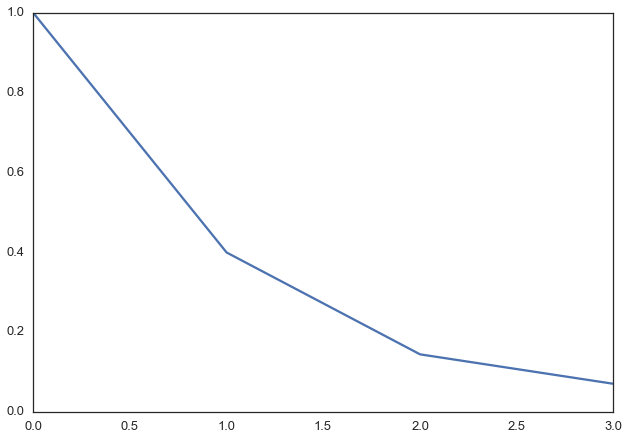

In [12]:
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", context="talk")

pca = PCA()
pca.fit(df_norm)

labels = ['pc'+ str(pc) for pc in range(1,5)]
var = pca.explained_variance_ratio_ / max(pca.explained_variance_ratio_)

plt.plot(var);

The plot method returns a plot of the variances (y-axis) associated with the PCs (x-axis). The Figure above is useful to decide how many PCs to retain for further analysis. In this simple case with only 4 PCs this is not a hard task and we can see that the first two PCs explain most of the variability in the data.

In [16]:
df_pca = pd.DataFrame(pca.transform(df_norm), columns=labels)
df_pca.head()

,pc1,pc2,pc3,pc4
0,-0.975660,1.122001,-0.439804,0.154697
1,-1.930538,1.062427,2.019500,-0.434175
2,-1.745443,-0.738460,0.054230,-0.826264
3,0.139999,1.108542,0.113422,-0.180974
4,-2.498613,-1.527427,0.592541,-0.338559


In [345]:
!pip install us

In [13]:
import us
state_codes = [us.states.lookup(state).abbr for state in df.index]

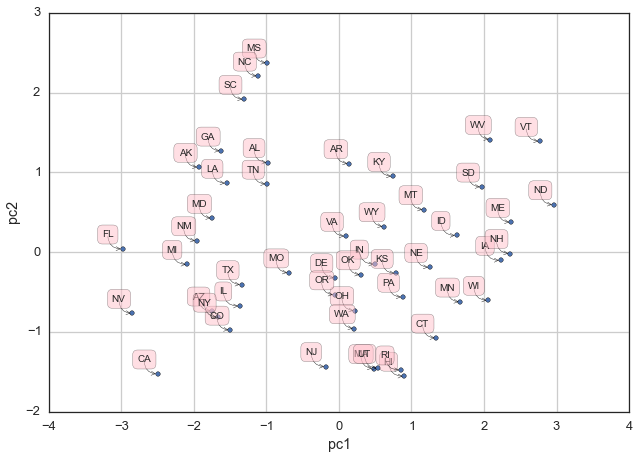

In [29]:
import random 
x = df_pca.pc1
y = df_pca.pc2
labels = list(df.index)

# x = df_norm.Murder
# y = df_norm.Rape
# df_norm.plot(kind = 'scatter', x = 'Murder', y = 'Rape');
df_pca.plot(kind = 'scatter', x = 'pc1', y = 'pc2');
for label, x, y in zip(state_codes, x, y):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 10),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'pink', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0.5'))

### Interpreting PCA

Reduced dataset shape: (50, 4)
Meaning of the 2 components:
-0.536 x Murder + -0.583 x Assault + -0.278 x UrbanPop + -0.543 x Rape
0.418 x Murder + 0.188 x Assault + -0.873 x UrbanPop + -0.167 x Rape


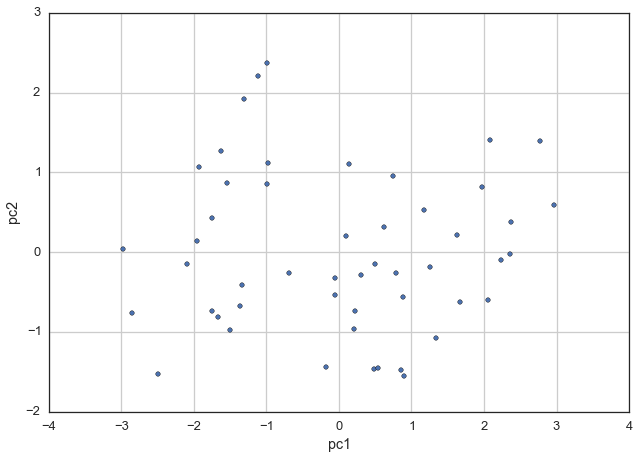

In [348]:
print "Reduced dataset shape:", df_pca.shape

df_pca.plot(kind = 'scatter', x = 'pc1', y = 'pc2');

print "Meaning of the 2 components:"
for component in pca.components_[:2]:
    print " + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            df.columns))

### Circle of Correlation


In [31]:
dfs

,Murder,Assault,UrbanPop,Rape
pc1,0.843976,0.918443,0.438117,0.855839
pc2,-0.416035,-0.187021,0.868328,0.166460


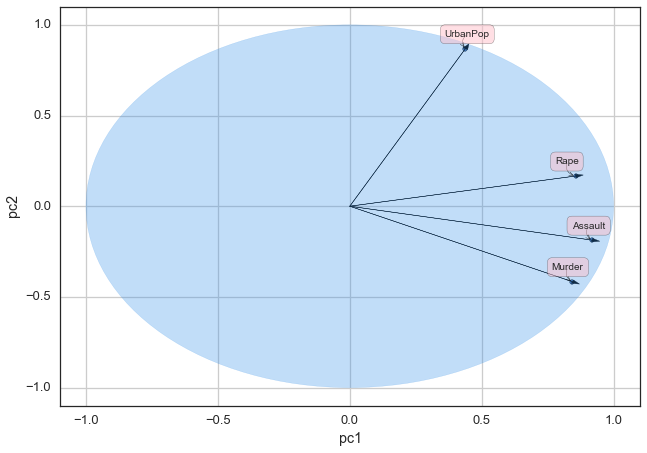

In [30]:
pcs = ['pc1','pc2']
corrs = [[np.corrcoef(df_pca[pc], df[feat])[0][1] * -1 for feat in df.columns] for pc in pcs]    
dfs = pd.DataFrame(corrs, columns=df.columns)
dfs.index = pcs
dfs.T.plot(kind='scatter',x='pc1',y='pc2')
for label, x, y in zip(df.columns, dfs.T.pc1, dfs.T.pc2):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 10),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'pink', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0.5'))
    plt.arrow( 0, 0, x, y, fc="k", ec="k")
    
circle1=plt.Circle((0,0),1,color='#3490e9', alpha=0.3)
fig = plt.gcf()
fig.gca().add_artist(circle1)
x1,x2,y1,y2 = plt.axis()
plt.axis((-1.1,1.1,-1.1,1.1));

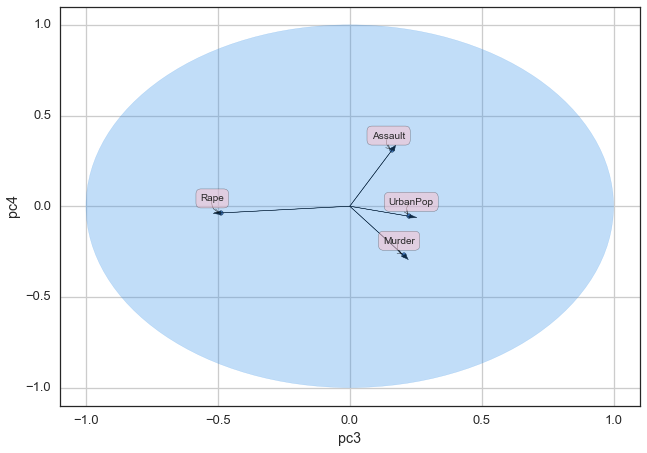

In [34]:
pcs = ['pc3','pc4']
corrs = [[np.corrcoef(df_pca[pc], df[feat])[0][1] * -1 for feat in df.columns] for pc in pcs]    
dfs = pd.DataFrame(corrs, columns=df.columns)
dfs.index = pcs
dfs.T.plot(kind='scatter',x='pc3',y='pc4')
for label, x, y in zip(df.columns, dfs.T.pc3, dfs.T.pc4):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 10),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'pink', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0.5'))
    plt.arrow( 0, 0, x, y, fc="k", ec="k")
    
circle1=plt.Circle((0,0),1,color='#3490e9', alpha=0.3)
fig = plt.gcf()
fig.gca().add_artist(circle1)
x1,x2,y1,y2 = plt.axis()
plt.axis((-1.1,1.1,-1.1,1.1));

## Linear Discriminant Analysis

**Principal Component Analysis (PCA)** applied to this data identifies the combination of attributes (principal components, or directions in the feature space) that account for the most variance in the data. Here we plot the different samples on the 2 first principal components.

**Linear Discriminant Analysis (LDA)** tries to identify attributes that account for the most variance between classes. In particular, LDA, in contrast to PCA, is a supervised method, using known class labels.

explained variance ratio (first two components): [ 0.92461621  0.05301557]


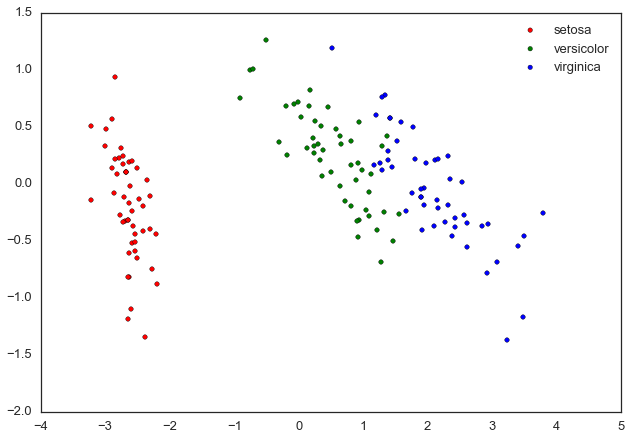

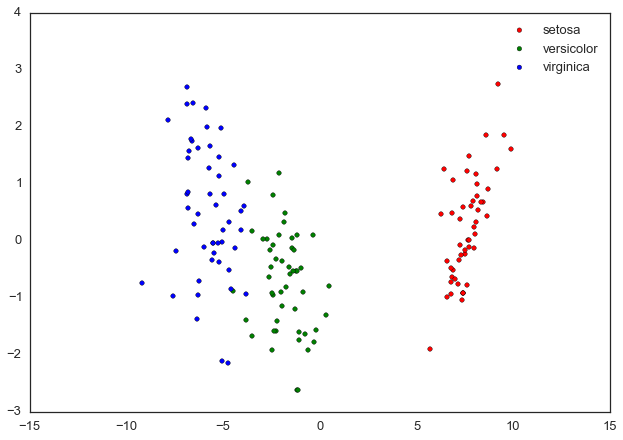

In [36]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.lda import LDA

iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LDA(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], c=c, label=target_name)
plt.legend()
plt.title = 'PCA of IRIS dataset'

plt.figure()
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], c=c, label=target_name)
plt.legend()
plt.title = 'LDA of IRIS dataset'

plt.show();

## Kernel Methods in PCA

There are three standard kernels:

* linear: $$K(x,x’) = x^{T}x$$
* polynomial: $$K(x,x’) = (x^{T}x’ + 1)^{d}$$
* gaussian (rdf): $$K(x,x’) = exp(- \gamma ||x - x’||^{2})$$

PCA can use kernels methods to produce new clarity around the structure of the data. In particular, KPCA is most often used for image de-noising and pattern recognition (or commonly novelty detection). KPCA is particularly useful for extracting nonlinear features, though like standard PCA, the interpretation is not always straightforward!

![](assets/MLSS-2012-Fukumizu-Kernel-Methods-for-Statistical-Learning_034.png)

This example shows that Kernel PCA is able to find a projection of the data that makes data linearly separable.

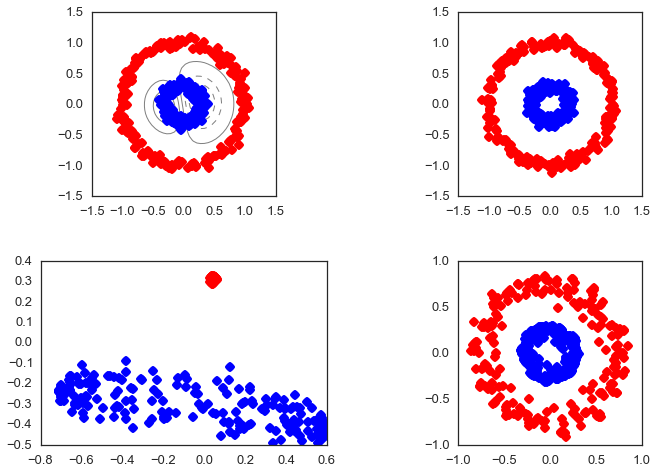

In [353]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles

np.random.seed(0)

X, y = make_circles(n_samples=400, factor=.3, noise=.05)

kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10)
X_kpca = kpca.fit_transform(X)
X_back = kpca.inverse_transform(X_kpca)
pca = PCA()
X_pca = pca.fit_transform(X)

# Plot results

plt.figure()
plt.subplot(2, 2, 1, aspect='equal')
plt.title = "Original space"
reds = y == 0
blues = y == 1

plt.plot(X[reds, 0], X[reds, 1], "ro")
plt.plot(X[blues, 0], X[blues, 1], "bo")
plt.xlabel = "$x_1$"
plt.ylabel = "$x_2$"

X1, X2 = np.meshgrid(np.linspace(-1.5, 1.5, 50), np.linspace(-1.5, 1.5, 50))
X_grid = np.array([np.ravel(X1), np.ravel(X2)]).T
# projection on the first principal component (in the phi space)
Z_grid = kpca.transform(X_grid)[:, 0].reshape(X1.shape)
plt.contour(X1, X2, Z_grid, colors='grey', linewidths=1, origin='lower')

plt.subplot(2, 2, 2, aspect='equal')
plt.plot(X_pca[reds, 0], X_pca[reds, 1], "ro")
plt.plot(X_pca[blues, 0], X_pca[blues, 1], "bo")
plt.title = "Projection by PCA"
plt.xlabel = "1st principal component"
plt.ylabel = "2nd component"

plt.subplot(2, 2, 3, aspect='equal')
plt.plot(X_kpca[reds, 0], X_kpca[reds, 1], "ro")
plt.plot(X_kpca[blues, 0], X_kpca[blues, 1], "bo")
plt.title = "Projection by KPCA"
plt.xlabel = "1st principal component in space induced by $\phi$"
plt.ylabel = "2nd component"

plt.subplot(2, 2, 4, aspect='equal')
plt.plot(X_back[reds, 0], X_back[reds, 1], "ro")
plt.plot(X_back[blues, 0], X_back[blues, 1], "bo")
plt.title = "Original space after inverse transform"
plt.xlabel = "$x_1$"
plt.ylabel = "$x_2$"

plt.subplots_adjust(0.02, 0.10, 0.98, 0.94, 0.04, 0.35)

plt.show()

## Classwork

1. Work through the iris data set include in sklearn and determine how many principal components are required to accurately predict the data. Note: you should be able to graph it, so it has to be one or two :)

2. Try using a kernel to make the PCs have an even clearer distinction between each class label in the iris data set. Submit your parameters as a Gist.

3. The data from the KPCA section of lecture is from [this data](https://gist.github.com/tijptjik/9408623). See what you can reproduce using KPCA to accurately predict the "Wine" column.

4. How can PCA/KPCA be used in your final project? Continue practicing your application of these data sets and see how you can improve your current model implementation.

### Optional 

Using a student login [dataset](data : https://raw.githubusercontent.com/ga-students/DAT_SF_10/master/Labs/Lab6/student_logins.csv), Build a program that can predict the duration time of an online student.

#### Details about Data Set:
* Data is in student_logins.csv
* Each session has start and end time
* Students have multiple sessions and sometimes take different
classes
* Account created date is an indicator of how long that student
has been participating in the online class

#### Guidelines:
* Duration time will need to be calculated using the start and end
times
* Explain how and why you selected features for you model
* Create a measurement of how well the model performs

### Uses and misuses of PCA

#### Good
* To compress the data so it takes up less computer memory / disk space
* To reduce the dimensions of the input so as to speed up a learning algorythm (e.g. image processing)
* To visualise high-dimensional data (by choosing k = 2 or k = 3)

#### Not Recommended
* Before trying a learning system without it with raw values
* To preventing overfitting (regularisation much better, uses y labels, doesn't throw away variance)


![break](assets/resources.png)

### Tutorial

* [A Tutorial on Principal Component Analysis](http://shlens.wordpress.com/tutorials/)
* [Dimensionality Reduction A Short Tutorial](http://www.math.uwaterloo.ca/~aghodsib/courses/f06stat890/readings/tutorial_stat890.pdf)
* [Stanford PCA Tutorial](http://ufldl.stanford.edu/wiki/index.php/PCA)
* [Aaron's PCA/3d/clustering post](http://planspace.org/2013/02/03/pca-3d-visualization-and-clustering-in-r/)

#### Extra

* [Sample size vs. dimensionality](http://www.cbcb.umd.edu/~salzberg/docs/murthy_thesis/survey/node16.html)
* [The Curse of Dimensionality in classification](http://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/)
* [Scaling your Data](http://sebastianraschka.com/Articles/2014_about_feature_scaling.html)

### Academic

* [Dimensionality Reduction Methods](http://www.stat-d.si/mz/mz2.1/dambra.pdf)
* [A survey of dimension reduction techniques](http://www.cc.gatech.edu/~isbell/tutorials/dimred-survey.pdf)
* [Random projection in dimensionality reduction: Applications to image and text data](http://users.ics.aalto.fi/ella/publications/randproj_kdd.pdf)
* [t-Distributed Stochastic Neighbor Embedding](http://lvdmaaten.github.io/tsne/)


#### Sample Size

* [Sample size determination](http://en.wikipedia.org/wiki/Sample_size_determination)
* [Optimal number of features as a function of sample size for various classiﬁcation rules](http://bioinformatics.oxfordjournals.org/content/21/8/1509.full.pdf+html)
* [Sample size and statistical power considerations in high-dimensionality data settings: a comparative study of classification algorithms](http://link.springer.com/content/pdf/10.1186%2F1471-2105-11-447.pdf)
* [Some considerations of classification for high dimension low-sample size data](http://smm.sagepub.com/content/early/2011/11/22/0962280211428387.abstract)